In [ ]:
import sys
# sys.path.append('/content/drive/MyDrive/imperial/RL/CW2')
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss, train_model, hyper_param_testing, get_results_and_dqn_policy_net, train_model_for_test, visualise_DQN

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Configuring Pytorch

from tqdm import tqdm

import json
import pickle
import optuna
from optuna.trial import TrialState

/home/qtlim/anaconda3/envs/rl_cw2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
NUM_RUNS = 10

In [ ]:
env = gym.make('CartPole-v1')
env.reset()

(array([ 0.01775053,  0.04493718,  0.02899872, -0.04880178], dtype=float32),
 {})

### Creating baseline study using Optuna

In [ ]:
# Using optuna to create a study

def define_model(trial, lr, epsilon, epsilon_percentage, network_architecture, optimizer_type, activation_func, batch_size, replay_buffer_size, update_target_num):

  env = gym.make('CartPole-v1')
  policy_net = DQN(network_architecture, activation_func) # changed policy network archi as variable
  target_net = DQN(network_architecture, activation_func) # changed target network archi as variable
  update_target(target_net, policy_net)
  target_net.eval()

  # update number for how many episodes between to update target (should be changed)
  update_target_num = update_target_num

  epsilon_min = 0.05

  # changed optimizer and lr as a variable
  optimizer = getattr(optim, optimizer_type)(policy_net.parameters(), lr=lr)

  memory = ReplayBuffer(int(replay_buffer_size))

  for i_episode in tqdm(range(300)):
    # if (i_episode+1) % 50 == 0:
    #   print("episode ", i_episode+1, "/", 300)

    observation, info = env.reset()
    state = torch.tensor(observation).float()

    done = False
    terminated = False
    t = 0
    while not (done or terminated):

      # Select and perform an action
      action = epsilon_greedy(epsilon, policy_net, state)
      if epsilon > epsilon_min:
        epsilon = epsilon*epsilon_percentage
      else:
        epsilon = epsilon_min

      observation, reward, done, terminated, info = env.step(action)
      reward = torch.tensor([reward])
      action = torch.tensor([action])
      next_state = torch.tensor(observation).reshape(-1).float()

      memory.push([state, action, next_state, reward, torch.tensor([done])])

      # Move to the next state
      state = next_state

      # Perform one step of the optimization (on the policy network)
      if not len(memory.buffer) < batch_size:
        transitions = memory.sample(batch_size)
        state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
        # Compute loss
        mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
        # Optimize the model
        optimizer.zero_grad()
        mse_loss.backward()
        optimizer.step()

      t += 1

    # Update the target network, copying all weights and biases in DQN
    if i_episode % update_target_num == 0:
      update_target(target_net, policy_net)

    trial.report(t, step=i_episode)
    if trial.should_prune():
      raise optuna.TrialPruned()

  return t


In [ ]:
def objective(trial):
  # lr = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)
  lr = trial.suggest_categorical("learning_rate", [0.1, 0.01, 0.001, 0.0001])
  epsilon = trial.suggest_float("epsilon", 0.1, 1.0, step=0.1)
  epsilon_percentage = trial.suggest_categorical("epsilon_percentage", [0.9, 0.99, 1.0])
  epsilon_min = 0.05

  network_architecture = trial.suggest_categorical("network_architecture",
                                                   [# 1 hidden layer up to 256 as maximum total hidden layer size
                                                   [4, 16, 2],
                                                   [4, 32, 2],
                                                   [4, 64, 2],
                                                   [4, 128, 2],
                                                   [4, 256, 2],
                                                   # 2 hidden layers with 2nd hidden layer size smaller than first to allow better convergence to 2 output size
                                                   [4, 16, 16, 2],
                                                   [4, 32, 16, 2],
                                                   [4, 64, 16, 2],
                                                   [4, 128, 16, 2],
                                                   [4, 32, 32, 2],
                                                   [4, 64, 32, 2],
                                                   [4, 128, 32, 2],
                                                   [4, 64, 64, 2],
                                                   [4, 128, 64, 2],
                                                   [4, 128, 128, 2],
                                                   # 3 hidden layers with pyramid architecture
                                                   [4, 16, 32, 16, 2],
                                                   [4, 32, 64, 32, 2],
                                                   [4, 64, 128, 64, 2]]
  )
  optimizer_type = trial.suggest_categorical("optimizer_type", ["Adam", "RMSprop", "SGD"])
  activation_func = trial.suggest_categorical("activation_func", ["sigmoid", "tanh", "relu", "leaky_relu"])  # some common activ func seen in papers
  batch_size = trial.suggest_categorical("batch_size", [1, 5, 10, 15, 20])

  replay_buffer_size = trial.suggest_categorical("replay_buffer_size", [100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000, 25000])
  update_target_num = trial.suggest_categorical("update_target_num", [1, 2, 5, 10])

  t = define_model(trial, lr, epsilon, epsilon_percentage, network_architecture, optimizer_type, activation_func, batch_size, replay_buffer_size)
  value = t

  return value


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, timeout=6000)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-15 18:33:45,822] A new study created in memory with name: no-name-a36a6236-f2cf-4496-af25-f3a83b232465
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 16, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 32, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [4, 64, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: 

Study statistics: 
  Number of finished trials:  1000
  Number of pruned trials:  891
  Number of complete trials:  109
Best trial:
  Value:  500.0
  Params: 
    learning_rate: 0.001
    epsilon: 0.9
    epsilon_percentage: 0.99
    network_architecture: [4, 16, 16, 2]
    optimizer_type: Adam
    activation_func: relu
    batch_size: 20
    replay_buffer_size: 10000


### Testing to see if model hyperparameter suggested by Optuna for the baseline DQN is of good results

#### Average return of network_architecture = [4, 16, 16, 2]

In [ ]:
results_baseline_dict = {}

runs_results_baseline = train_model(lr = 0.001,
                                    epsilon = 0.9,
                                    epsilon_percentage = 0.99,
                                    network_architecture = [4, 16, 16, 2],
                                    optimizer_type = "Adam",
                                    activation_func = "relu",
                                    batch_size = 20,
                                    replay_buffer_size = 10000,
                                    update_target_num = 1)

# Saving baseline params values to best_data.json file
final_results_baseline = []
final_results = torch.tensor(runs_results_baseline)
means = final_results.float().mean(0)
stds = final_results.float().std(0)
final_results_baseline.append(means.tolist())
final_results_baseline.append(stds.tolist())

# saving data into json file for ease of plotting later
results_baseline_dict["runs_results_baseline"] = final_results_baseline

with open('baseline_data.json', 'w') as fp:
    json.dump(results_baseline_dict, fp)

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

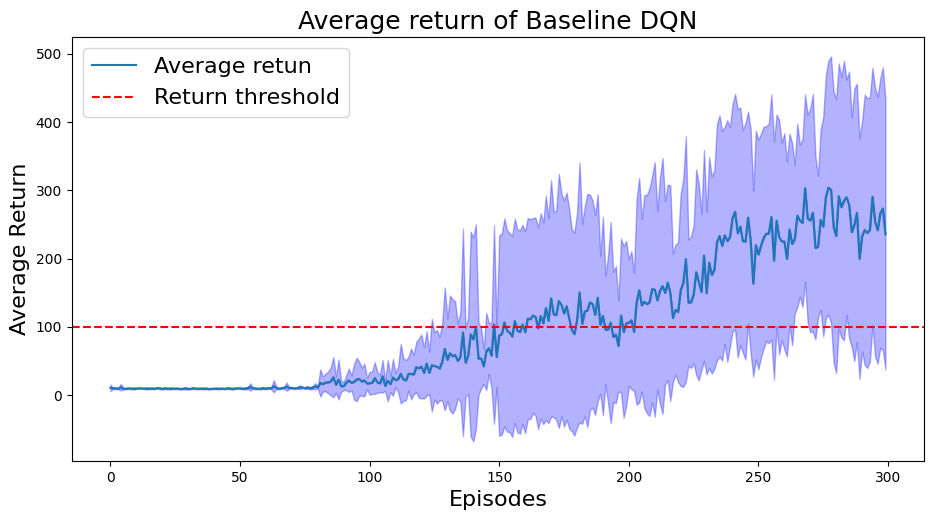

In [ ]:
# Opening data to plot
with open('baseline_data.json', 'r') as fp:
    data = json.load(fp)

final_results_baseline = data["runs_results_baseline"]
final_results_baseline = torch.tensor(final_results_baseline)
means = final_results_baseline[0]
stds = final_results_baseline[1]

plt.figure(figsize=(11,5.5))
plt.plot(torch.arange(300), means, label="Average retun")
plt.axhline(y = 100, color = 'r', linestyle = '--', label="Return threshold")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')


plt.ylabel("Average Return", fontsize= 16)
plt.xlabel("Episodes", fontsize= 16)
plt.title("Average return of Baseline DQN", fontsize= 18)
plt.legend(fontsize=16, loc ="upper left")

plt.show()

## Hyperparameter testing using baseline DQN model

In [ ]:
NUM_RUNS = 10
results_dict = {}

### varying learning rate

for 0.100000 : 
Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode

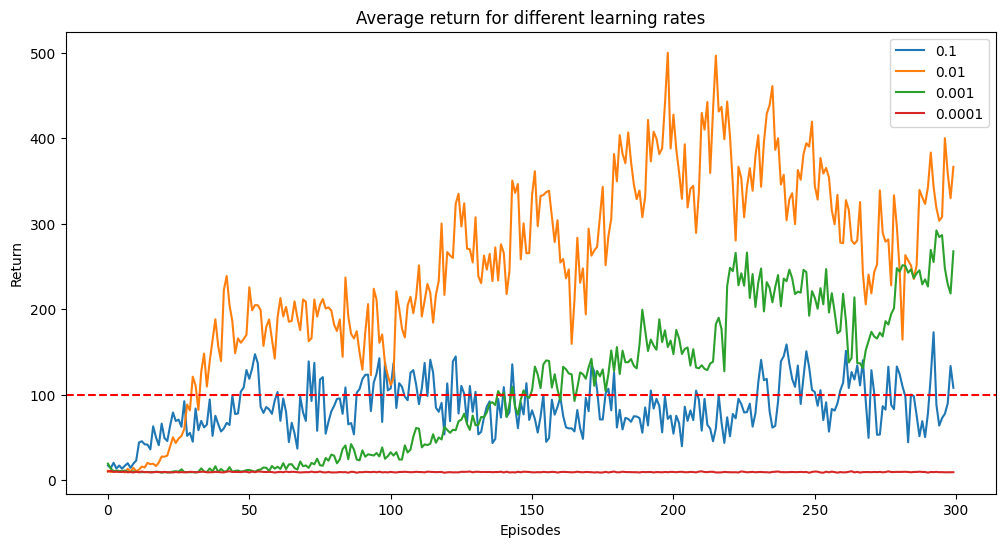

In [ ]:
# running testing with specific parameter's flag to be True
final_results = hyper_param_testing(lr_flag=True)

# Getting results and saving into json file to read if needed
mean_final_results = []

for result in final_results:
  means = torch.tensor(result).float().mean(0)
  mean_final_results.append(means)

new_mean_final_list = []
for i in mean_final_results:
    new_mean_final_list.append(i.tolist())

results_dict["lr"] = new_mean_final_list

with open('mean_data.json', 'w') as fp:
    json.dump(results_dict, fp)

# Plotting the learning curve
plt.figure(figsize=(12,6))
labels = [0.1, 0.01, 0.001, 0.0001]
for index, mean_return in enumerate(mean_final_results):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different learning rates")
plt.show()



### varying epsilon

for 0.100000 : 
Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300


episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 9 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 10 of 10
ep

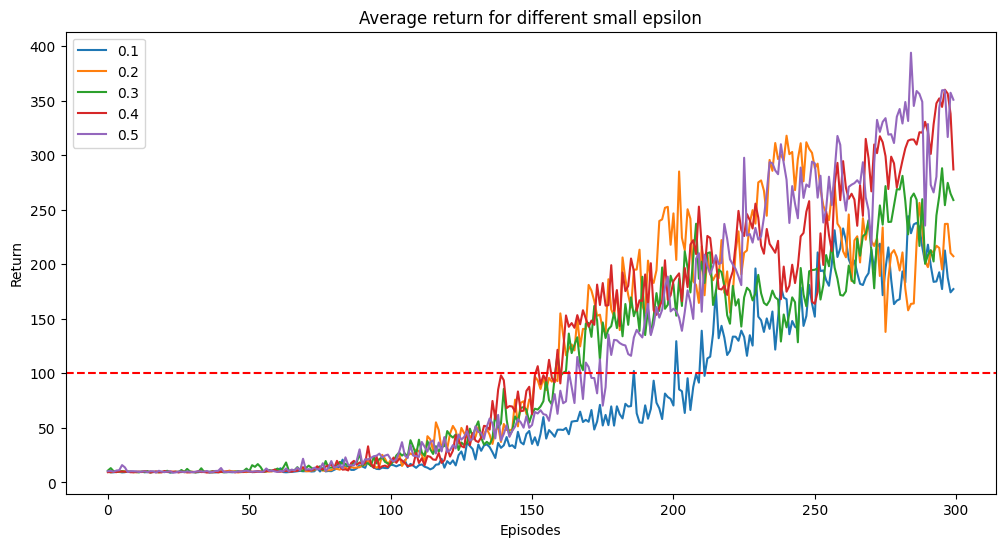

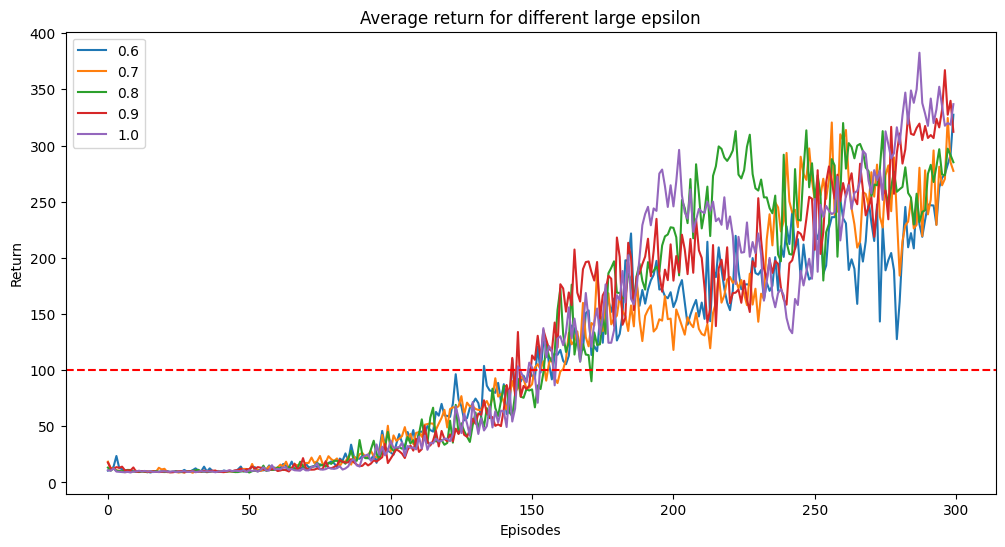

In [ ]:
# running testing with specific parameter's flag to be True
final_results = hyper_param_testing(epsilon_flag=True)

# Getting results and saving into json file to read if needed
mean_final_results = []

for result in final_results:
  means = torch.tensor(result).float().mean(0)
  mean_final_results.append(means)

new_mean_final_list = []
for i in mean_final_results:
    new_mean_final_list.append(i.tolist())

results_dict["epsilon"] = new_mean_final_list

with open('mean_data.json', 'w') as fp:
    json.dump(results_dict, fp)

# Plotting the learning curve
plt.figure(figsize=(12,6))
labels = [0.1, 0.2, 0.3, 0.4, 0.5]
for index, mean_return in enumerate(mean_final_results[0:5]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different small epsilon")
plt.show()

plt.figure(figsize=(12,6))
labels = [0.6, 0.7, 0.8, 0.9, 1.0]
for index, mean_return in enumerate(mean_final_results[5:10]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different large epsilon")
plt.show()



### varying epsilon decay rate

for 0.900000 : 
Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode

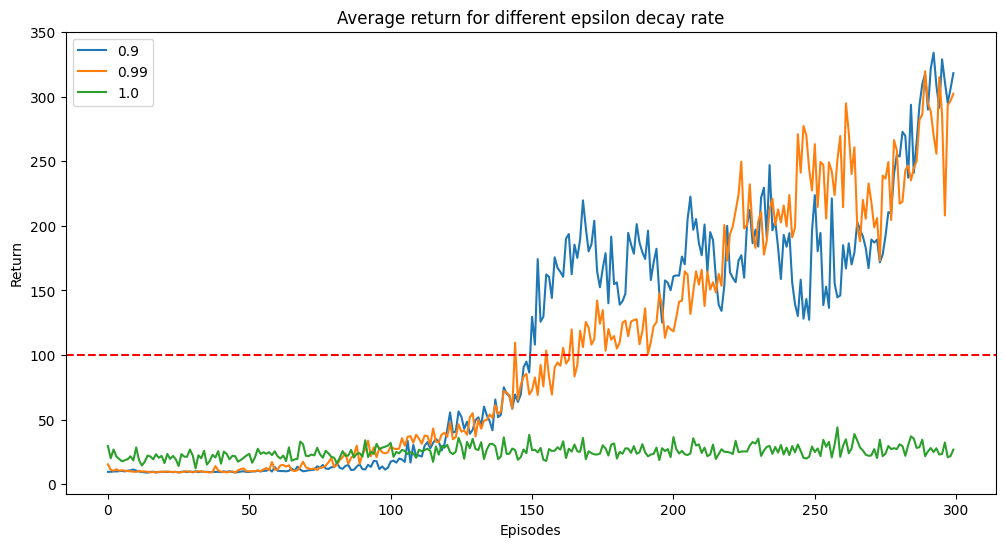

In [ ]:
# running testing with specific parameter's flag to be True
final_results = hyper_param_testing(epsilon_percentage_flag=True)

# Getting results and saving into json file to read if needed
mean_final_results = []

for result in final_results:
  means = torch.tensor(result).float().mean(0)
  mean_final_results.append(means)

new_mean_final_list = []
for i in mean_final_results:
    new_mean_final_list.append(i.tolist())

results_dict["epsilon_percentage"] = new_mean_final_list

with open('mean_data.json', 'w') as fp:
    json.dump(results_dict, fp)

# Plotting the learning curve
plt.figure(figsize=(12,6))
labels = [0.9, 0.99, 1.0]
for index, mean_return in enumerate(mean_final_results):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different epsilon decay rate")
plt.show()



### varying network_architecture

for [4, 16, 2] : 
Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episo

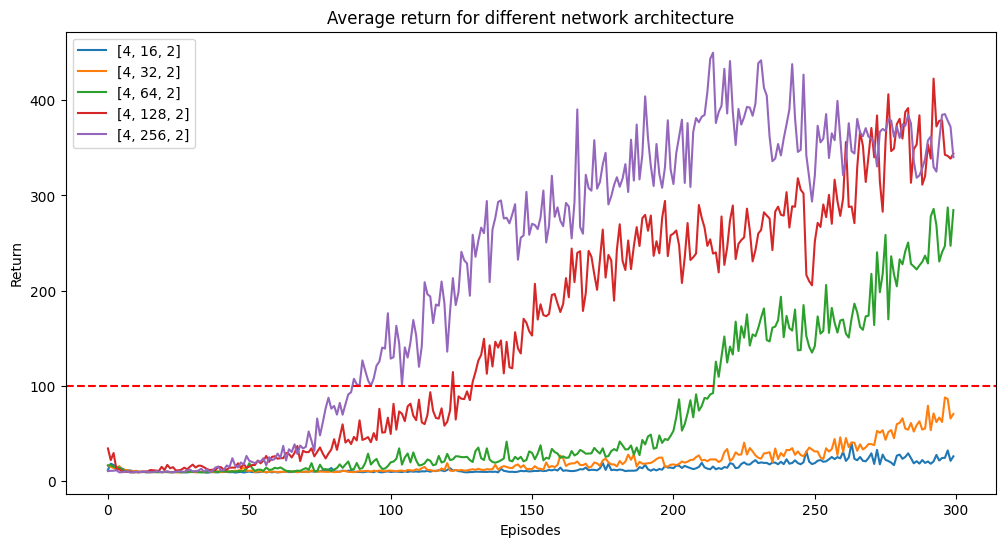

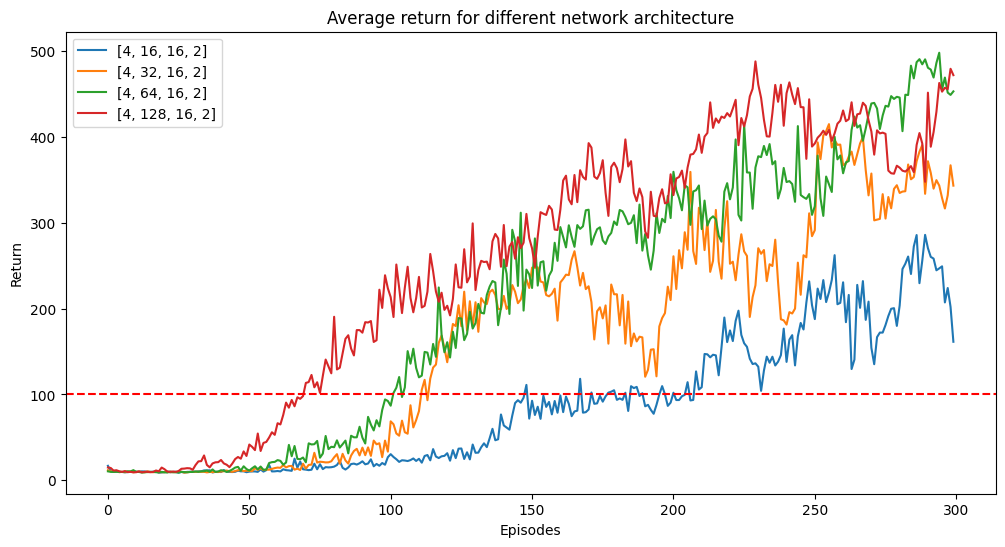

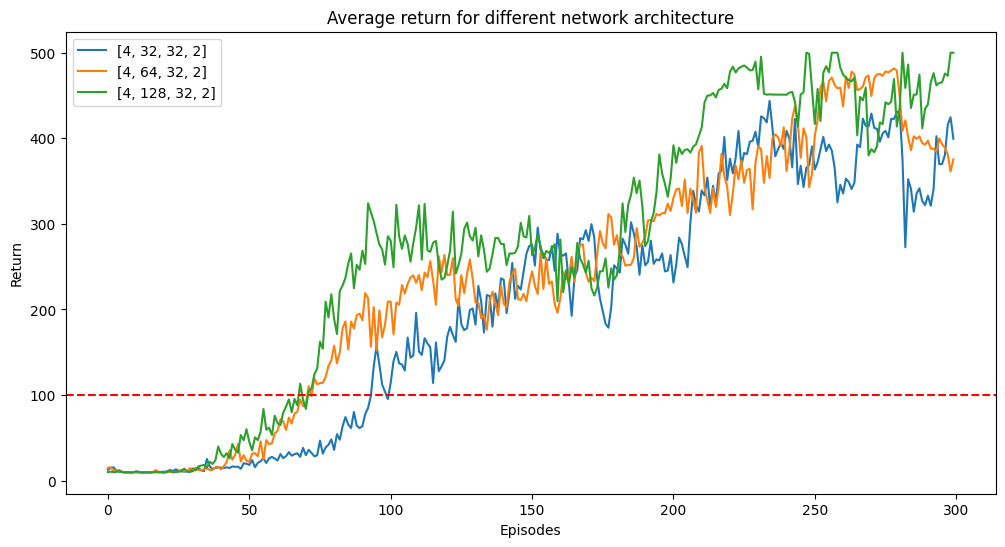

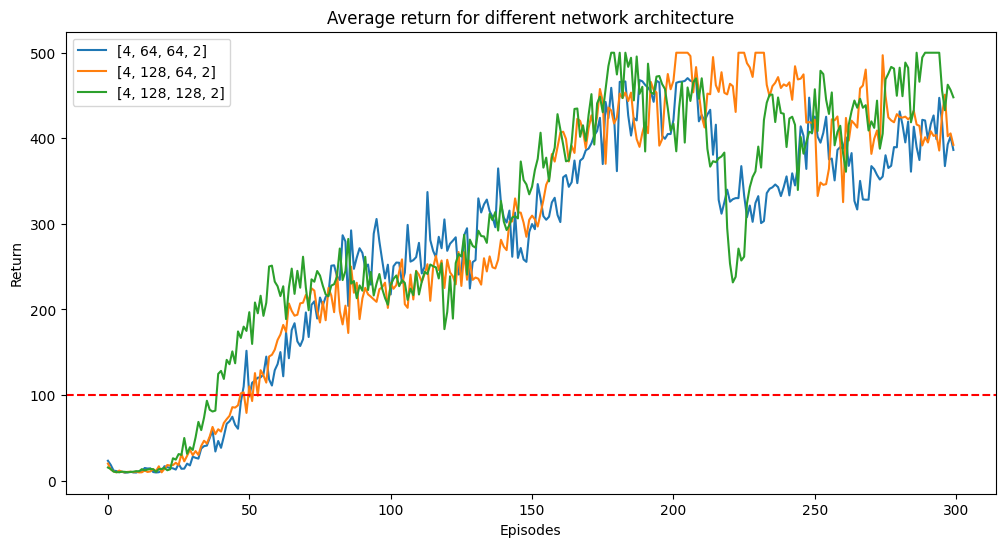

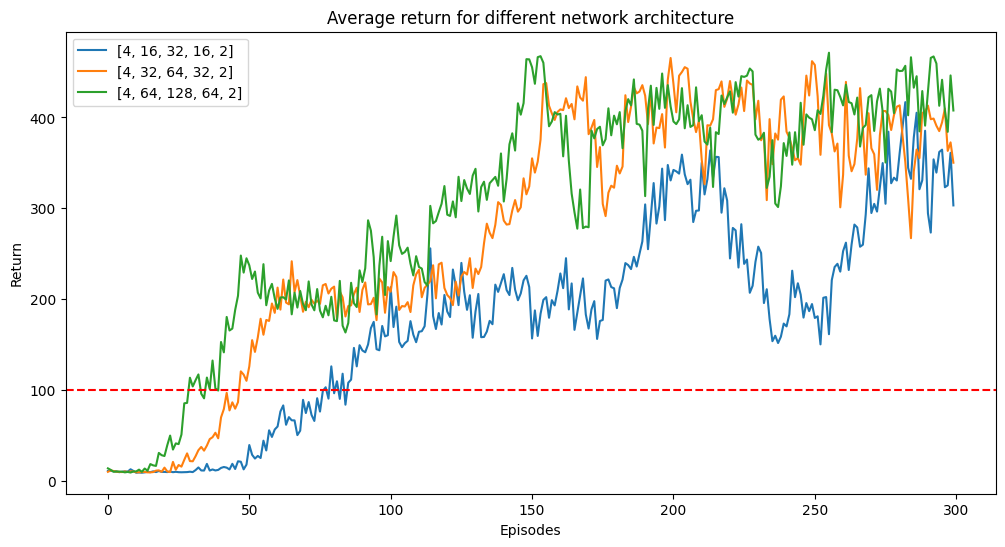

In [ ]:
# running testing with specific parameter's flag to be True
final_results = hyper_param_testing(network_architecture_flag=True)

# Getting results and saving into json file to read if needed
mean_final_results = []

for result in final_results:
  means = torch.tensor(result).float().mean(0)
  mean_final_results.append(means)

new_mean_final_list = []
for i in mean_final_results:
    new_mean_final_list.append(i.tolist())

results_dict["network_architecture"] = new_mean_final_list

with open('mean_data.json', 'w') as fp:
    json.dump(results_dict, fp)

# Plotting the learning curve
plt.figure(figsize=(12,6))
labels = [# 1 hidden layer up to 256 as maximum total hidden layer size
          [4, 16, 2],
          [4, 32, 2],
          [4, 64, 2],
          [4, 128, 2],
          [4, 256, 2]]
for index, mean_return in enumerate(mean_final_results[0:5]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different network architecture")
plt.show()

plt.figure(figsize=(12,6))
labels = [ # 2 hidden layers with 2nd hidden layer size smaller than first to allow better convergence to 2 output size
          [4, 16, 16, 2],
          [4, 32, 16, 2],
          [4, 64, 16, 2],
          [4, 128, 16, 2]]
for index, mean_return in enumerate(mean_final_results[5:9]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different network architecture")
plt.show()

plt.figure(figsize=(12,6))
labels = [[4, 32, 32, 2],
          [4, 64, 32, 2],
          [4, 128, 32, 2]]
for index, mean_return in enumerate(mean_final_results[9:12]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different network architecture")
plt.show()

plt.figure(figsize=(12,6))
labels = [[4, 64, 64, 2],
          [4, 128, 64, 2],
          [4, 128, 128, 2]]
for index, mean_return in enumerate(mean_final_results[12:15]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different network architecture")
plt.show()

plt.figure(figsize=(12,6))
labels = [# 3 hidden layers with pyramid architecture
          [4, 16, 32, 16, 2],
          [4, 32, 64, 32, 2],
          [4, 64, 128, 64, 2]]
for index, mean_return in enumerate(mean_final_results[15:18]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different network architecture")
plt.show()

### varying optimizer_type

for Adam : 
Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  10

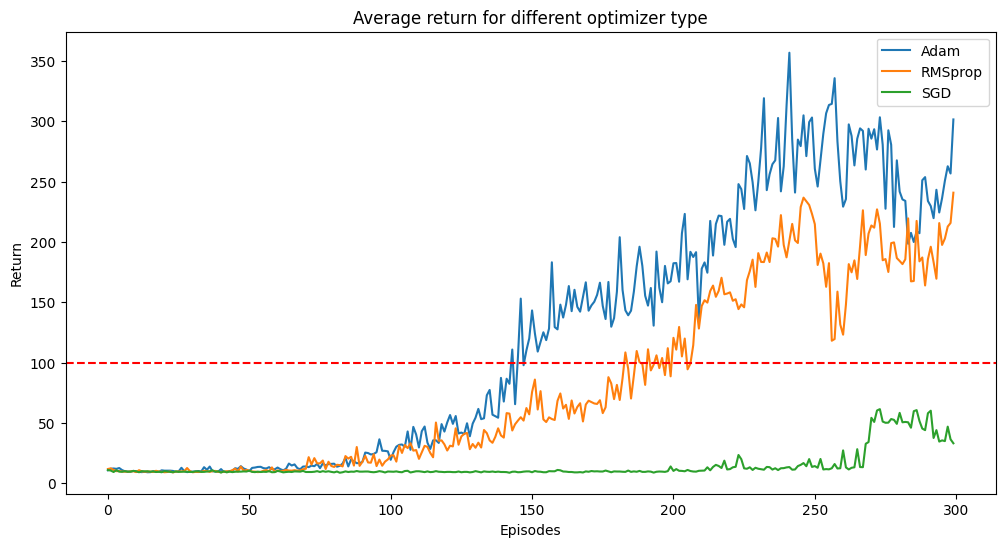

In [ ]:
# running testing with specific parameter's flag to be True
final_results = hyper_param_testing(optimizer_type_flag=True)

# Getting results and saving into json file to read if needed
mean_final_results = []

for result in final_results:
  means = torch.tensor(result).float().mean(0)
  mean_final_results.append(means)

new_mean_final_list = []
for i in mean_final_results:
    new_mean_final_list.append(i.tolist())

results_dict["optimizer_type"] = new_mean_final_list

with open('mean_data.json', 'w') as fp:
    json.dump(results_dict, fp)

# Plotting the learning curve
plt.figure(figsize=(12,6))
labels = ["Adam", "RMSprop", "SGD"]
for index, mean_return in enumerate(mean_final_results):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different optimizer type")
plt.show()



### varying activation_func

for sigmoid : 
Starting run 1 of 10


/home/qtlim/anaconda3/envs/rl_cw2/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episod

episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 10 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
for tanh : 
Starting run 1 of 10


/home/qtlim/anaconda3/envs/rl_cw2/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episod

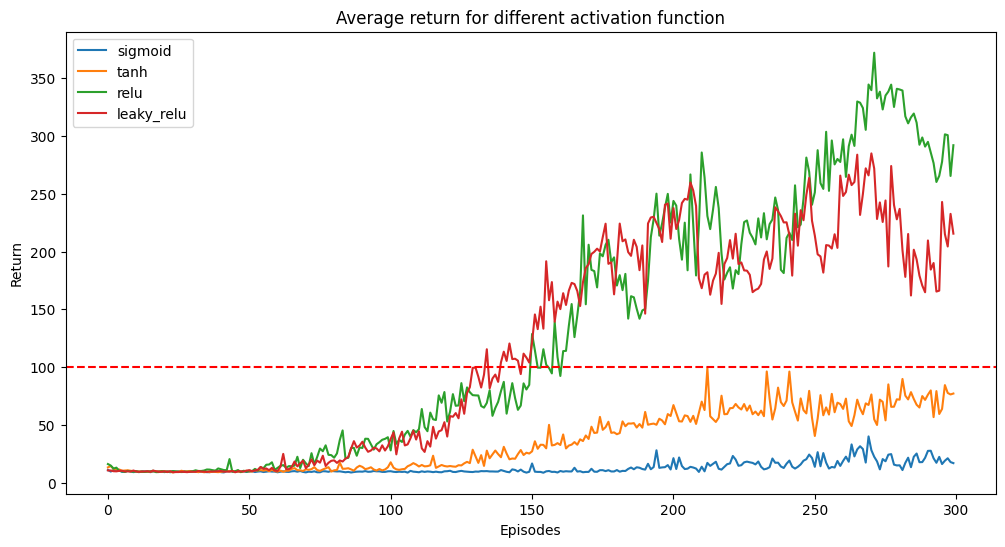

In [ ]:
# running testing with specific parameter's flag to be True
final_results = hyper_param_testing(activation_func_flag=True)

# Getting results and saving into json file to read if needed
mean_final_results = []

for result in final_results:
  means = torch.tensor(result).float().mean(0)
  mean_final_results.append(means)

new_mean_final_list = []
for i in mean_final_results:
    new_mean_final_list.append(i.tolist())

results_dict["activation_func"] = new_mean_final_list

with open('mean_data.json', 'w') as fp:
    json.dump(results_dict, fp)

# Plotting the learning curve
plt.figure(figsize=(12,6))
labels = ["sigmoid", "tanh", "relu", "leaky_relu"]
for index, mean_return in enumerate(mean_final_results):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different activation function")
plt.show()



### varying batch_size

for 1.000000 : 
Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300


episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 9 of 10
episode  50 / 300
epis

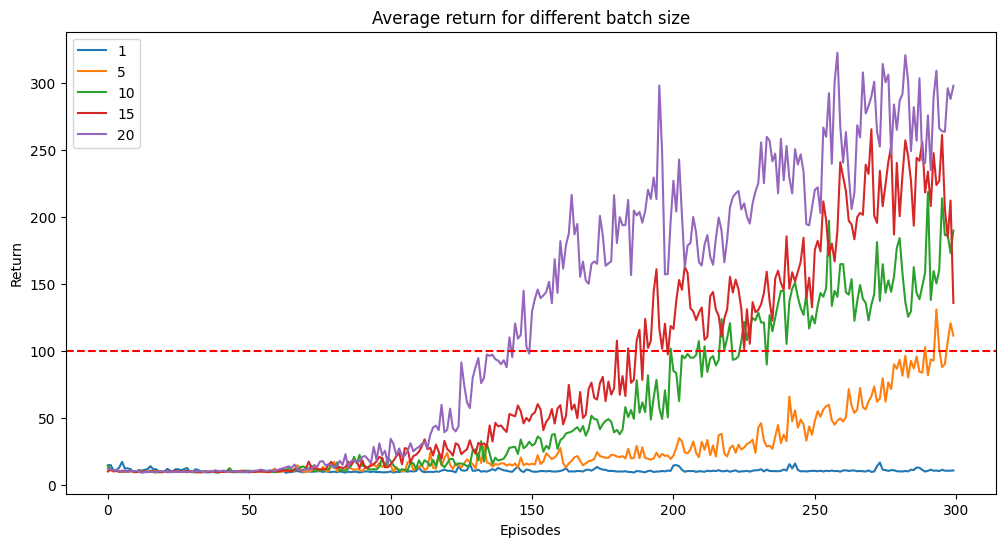

In [ ]:
# running testing with specific parameter's flag to be True
final_results = hyper_param_testing(batch_size_flag=True)

# Getting results and saving into json file to read if needed
mean_final_results = []

for result in final_results:
  means = torch.tensor(result).float().mean(0)
  mean_final_results.append(means)

new_mean_final_list = []
for i in mean_final_results:
    new_mean_final_list.append(i.tolist())

results_dict["batch_size"] = new_mean_final_list

with open('mean_data.json', 'w') as fp:
    json.dump(results_dict, fp)

# Plotting the learning curve
plt.figure(figsize=(12,6))
labels = [1, 5, 10, 15, 20]
for index, mean_return in enumerate(mean_final_results):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different batch size")
plt.show()



### varying replay_buffer_size

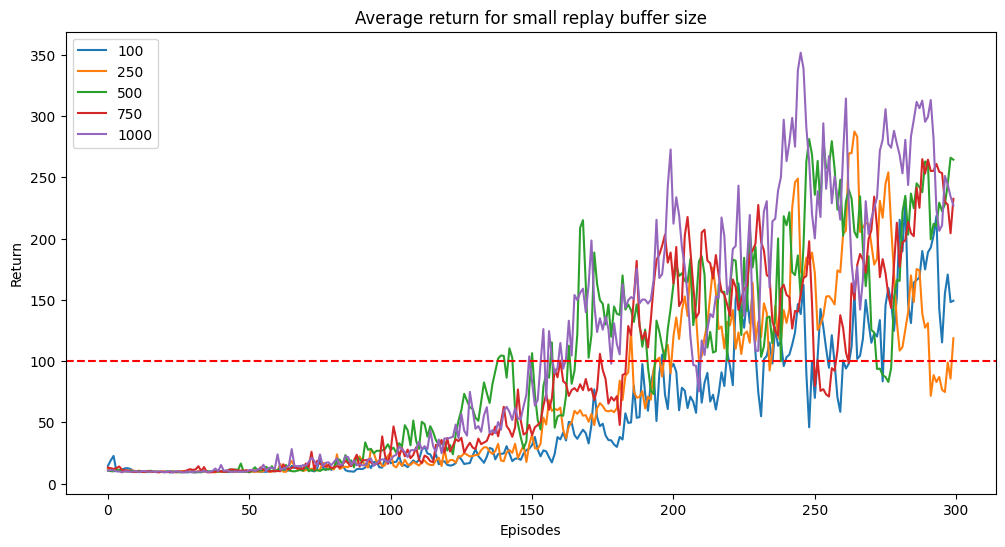

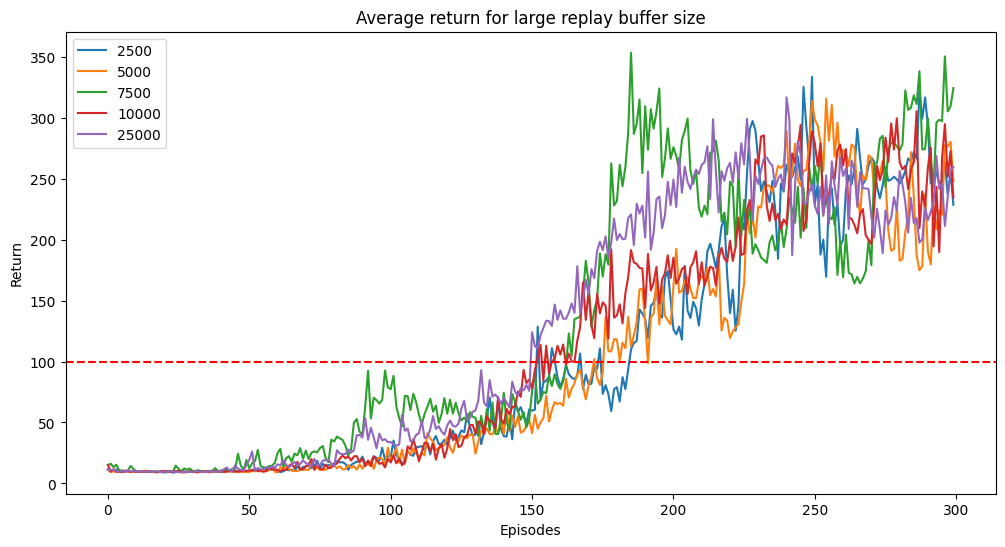

In [ ]:
# running testing with specific parameter's flag to be True
final_results = hyper_param_testing(replay_buffer_size_flag=True)

# Getting results and saving into json file to read if needed
mean_final_results = []

for result in final_results:
  means = torch.tensor(result).float().mean(0)
  mean_final_results.append(means)

new_mean_final_list = []
for i in mean_final_results:
    new_mean_final_list.append(i.tolist())

results_dict["replay_buffer_size"] = new_mean_final_list

with open('mean_data.json', 'w') as fp:
    json.dump(results_dict, fp)

# Plotting the learning curve
plt.figure(figsize=(12,6))
labels = [100, 250, 500, 750, 1000]
for index, mean_return in enumerate(mean_final_results[0:5]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for small replay buffer size")
plt.show()

plt.figure(figsize=(12,6))
labels = [2500, 5000, 7500, 10000, 25000]
for index, mean_return in enumerate(mean_final_results[5:10]):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for large replay buffer size")
plt.show()



### varying update_target_num

for 1.000000 : 
Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode

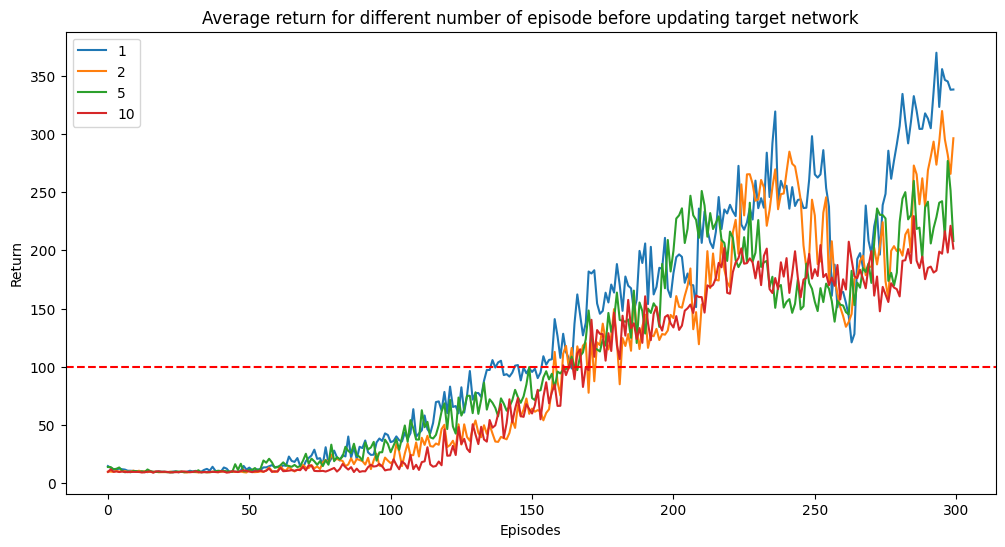

In [ ]:
# running testing with specific parameter's flag to be True
final_results = hyper_param_testing(update_target_num_flag=True)

# Getting results and saving into json file to read if needed
mean_final_results = []

for result in final_results:
  means = torch.tensor(result).float().mean(0)
  mean_final_results.append(means)

new_mean_final_list = []
for i in mean_final_results:
    new_mean_final_list.append(i.tolist())

results_dict["update_target_num"] = new_mean_final_list

with open('mean_data.json', 'w') as fp:
    json.dump(results_dict, fp)

# Plotting the learning curve
plt.figure(figsize=(12,6))
labels = [1, 2, 5, 10]
for index, mean_return in enumerate(mean_final_results):
  plt.plot(torch.arange(300), mean_return, label = labels[index])
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Return")
plt.xlabel("Episodes")
plt.legend()
plt.title("Average return for different number of episode before updating target network")
plt.show()

### Using best hyperparameter values to train tuned DQN

In [ ]:
tuned_DQN_results_dict = {}

In [ ]:
# Plotting the learning curve for best Hyperparameters derived from graph results

policy_net_tuned, runs_results_tuned = get_results_and_dqn_policy_net(lr = 0.001,
                                                          epsilon = 0.9,
                                                          epsilon_percentage = 0.99,
                                                          network_architecture = [4, 64, 64, 2],
                                                          optimizer_type = "Adam",
                                                          activation_func = "relu",
                                                          batch_size = 20,
                                                          replay_buffer_size = 10000,
                                                          update_target_num = 1)

result_tuned = []
final_results = torch.tensor(runs_results_tuned)
means = final_results.float().mean(0)
stds = final_results.float().std(0)
result_tuned.append(means.tolist())
result_tuned.append(stds.tolist())

tuned_DQN_results_dict["results_DQN_tuned"] = result_tuned

# saving tuned_results into json
with open('tuned_DQN_Adam.json', 'w') as fp:
    json.dump(tuned_DQN_results_dict, fp)

# Saving tuned model into pickel object
with open("tuned_DQN_Adam.pkl", 'wb') as file:
    pickle.dump(policy_net_tuned, file)


### getting untuned DQN data

In [ ]:
result_untuned_dict = {}

In [ ]:
runs_results_untuned = train_model(lr = 1.,
                           epsilon = 1.,
                           epsilon_percentage = 1.,
                           network_architecture = [4, 2],
                           optimizer_type = "SGD",
                           activation_func = "relu",
                           batch_size = 1,
                           replay_buffer_size = 1,
                           update_target_num = 1)

result_untuned = []
final_results = torch.tensor(runs_results_untuned)
means = final_results.float().mean(0)
stds = final_results.float().std(0)
result_untuned.append(means.tolist())
result_untuned.append(stds.tolist())

result_untuned_dict["run_result_untuned"] = result_untuned

with open('untuned_model.json', 'w') as fp:
    json.dump(result_untuned_dict, fp)

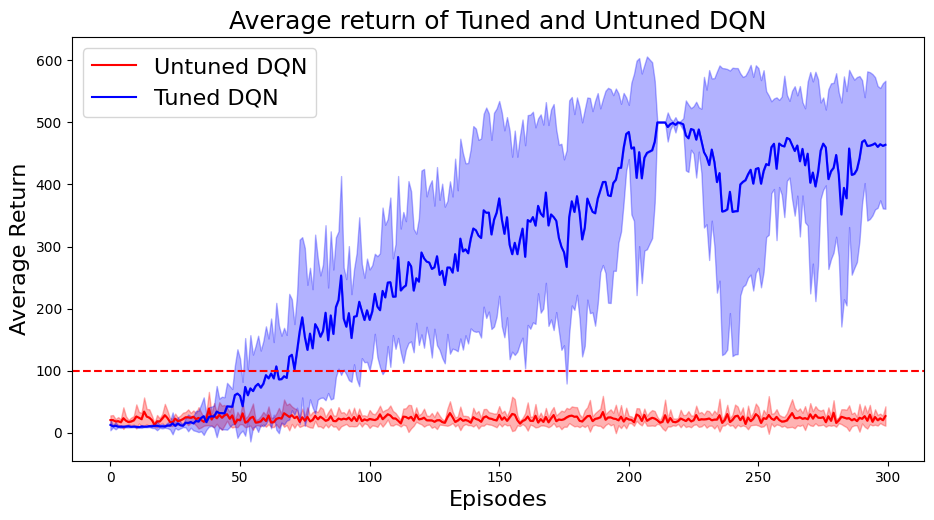

In [ ]:
#  getting tuned data
# load model from pickle file
with open("tuned_DQN_Adam.pkl", 'rb') as file:
    policy_net_tuned = pickle.load(file)

# to read out if needed
with open('tuned_DQN_Adam.json', 'r') as fp:
    tuned_data = json.load(fp)

result_tuned = tuned_data["results_DQN_tuned"]
result_tuned = torch.tensor(result_tuned)
means_tuned = result_tuned[0]
stds_tuned = result_tuned[1]


# getting untuned data
with open('untuned_model.json', 'r') as fp:
    untuned_data = json.load(fp)

result_untuned = untuned_data["run_result_untuned"]
result_untuned_mean_and_std = torch.tensor(result_untuned)
means_untuned = result_untuned_mean_and_std[0]
stds_untuned = result_untuned_mean_and_std[1]

# plotting tuned and untuned learning curves
plt.figure(figsize=(11,5.5))
plt.plot(torch.arange(300), means_untuned, color='r', label="Untuned DQN")
plt.fill_between(np.arange(300), means_untuned, means_untuned+stds_untuned, alpha=0.3, color='r')
plt.fill_between(np.arange(300), means_untuned, means_untuned-stds_untuned, alpha=0.3, color='r')

plt.plot(torch.arange(300), means_tuned, color='b', label="Tuned DQN")
plt.fill_between(np.arange(300), means_tuned, means_tuned+stds_tuned, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means_tuned, means_tuned-stds_tuned, alpha=0.3, color='b')
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.ylabel("Average Return", fontsize= 16)
plt.xlabel("Episodes", fontsize= 16)
plt.title("Average return of Tuned and Untuned DQN", fontsize= 18)
plt.legend(fontsize=16, loc ="upper left")

plt.show()

### Getting plot with and without $\epsilon$ decay

#### training tuned DQN with no decay

In [ ]:
tuned_without_decay_dict={}

In [ ]:
runs_results_no_decay = train_model(lr = 0.01,
                           epsilon = 0.9,
                           epsilon_percentage = 1.0,  # setting as no decay
                           network_architecture = [4, 128, 128, 2],
                           optimizer_type = "Adam",
                           activation_func = "relu",
                           batch_size = 20,
                           replay_buffer_size = 10000,
                           update_target_num = 1)

result_testing_no_decay_mean_and_std = []
final_results = torch.tensor(runs_results_no_decay)
means = final_results.float().mean(0)
stds = final_results.float().std(0)
result_testing_no_decay_mean_and_std.append(means.tolist())
result_testing_no_decay_mean_and_std.append(stds.tolist())

tuned_without_decay_dict["testing_no_decay"] = result_testing_no_decay_mean_and_std

with open('tuned_DQN_no_decay.json', 'w') as fp:
    json.dump(tuned_without_decay_dict, fp)


Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

#### training tuned DQN with low epsilon and no decay to see effects

In [ ]:
runs_results_no_decay_low_epsilon_dict = {}

In [ ]:
runs_results_no_decay_low_epsilon = train_model(lr = 0.01,
                                                epsilon = 0.2,
                                                epsilon_percentage = 1.0,  # setting as no decay
                                                network_architecture = [4, 128, 128, 2],
                                                optimizer_type = "Adam",
                                                activation_func = "relu",
                                                batch_size = 20,
                                                replay_buffer_size = 10000,
                                                update_target_num = 1)

result_testing_no_decay_low_epsilon = []
final_results = torch.tensor(runs_results_no_decay_low_epsilon)
means = final_results.float().mean(0)
stds = final_results.float().std(0)
result_testing_no_decay_low_epsilon.append(means.tolist())
result_testing_no_decay_low_epsilon.append(stds.tolist())

runs_results_no_decay_low_epsilon_dict["testing_no_decay_low_epsilon"] = result_testing_no_decay_low_epsilon

with open('tuned_DQN_no_decay_low_epsilon.json', 'w') as fp:
    json.dump(runs_results_no_decay_low_epsilon_dict, fp)

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

#### getting data for tuned DQN with decay and tuned DQN without decay and plotting

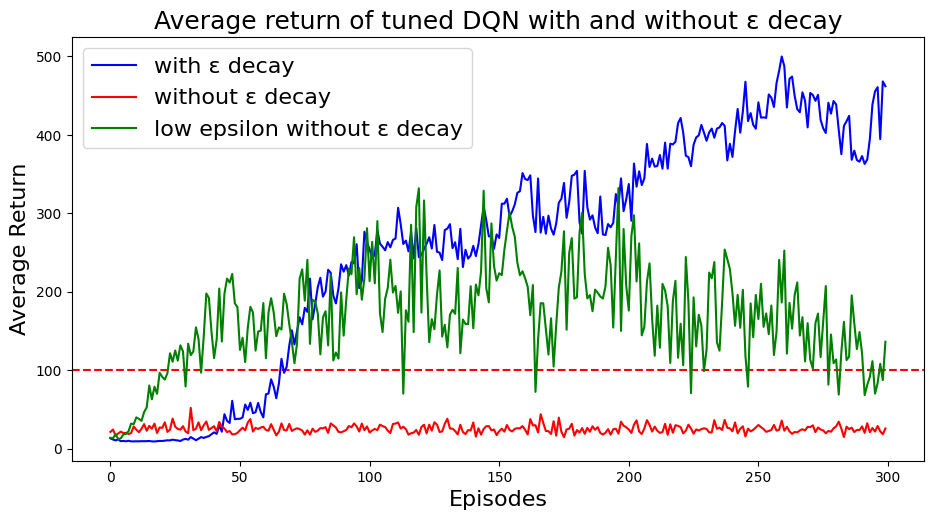

In [ ]:
# read out data without decay
with open('tuned_DQN_no_decay.json', 'r') as fp:
    data = json.load(fp)

final_results_no_decay = data["testing_no_decay"]
final_results_no_decay = torch.tensor(final_results_no_decay)
means_no_decay = final_results_no_decay[0]
stds_no_decay = final_results_no_decay[1]

# read out data with decay
with open('tuned_DQN_Adam_good.json', 'r') as fp:
    tuned_data = json.load(fp)

result_tuned = tuned_data["results_DQN_tuned"]
result_tuned = torch.tensor(result_tuned)
means_decay = result_tuned[0]
stds_decay = result_tuned[1]

# read out data with low epsilon and no decay
with open('tuned_DQN_no_decay_low_epsilon.json', 'r') as fp:
    data_no_decay_low_epsilon = json.load(fp)

no_decay_low_epsilon = data_no_decay_low_epsilon["testing_no_decay_low_epsilon"]
no_decay_low_epsilon = torch.tensor(no_decay_low_epsilon)
means_low_e = no_decay_low_epsilon[0]
stds_low_e = no_decay_low_epsilon[1]


plt.figure(figsize=(11,5.5))
plt.axhline(y = 100, color = 'r', linestyle = '--')
plt.plot(torch.arange(300), means_decay, color='b', label="with ε decay")

plt.plot(torch.arange(300), means_no_decay, color='r', label="without ε decay")

plt.plot(torch.arange(300), means_low_e, color='g', label="low epsilon without ε decay")

plt.ylabel("Average Return", fontsize= 16)
plt.xlabel("Episodes", fontsize= 16)
plt.title("Average return of tuned DQN with and without ε decay", fontsize= 18)
plt.legend(fontsize=16, loc ="upper left")
plt.show()

## Question 2

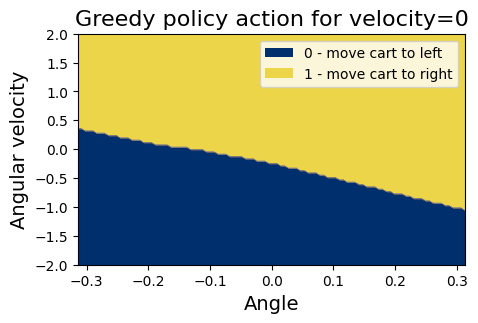

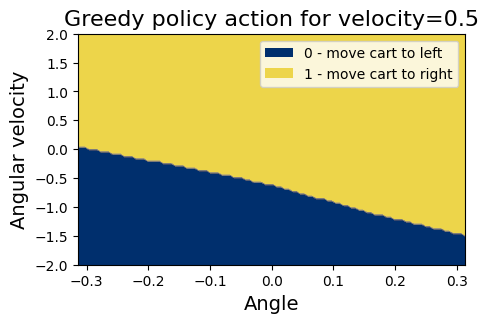

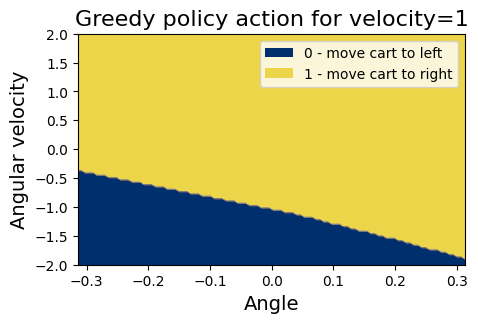

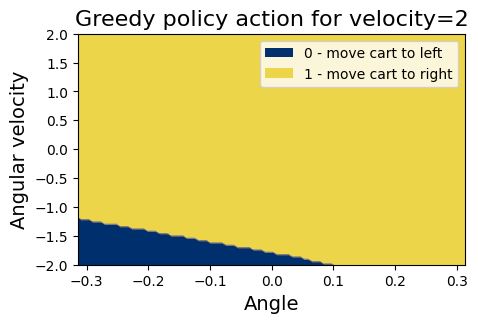

In [ ]:
# load model from pickle file
with open("tuned_DQN_Adam.pkl", 'rb') as file:
    policy_net_tuned = pickle.load(file)

cart_velocity = [0, 0.5, 1, 2]
visualise_DQN(policy_net_tuned, velocity=cart_velocity[0], q=False)

visualise_DQN(policy_net_tuned, velocity=cart_velocity[1], q=False)

visualise_DQN(policy_net_tuned, velocity=cart_velocity[2], q=False)

visualise_DQN(policy_net_tuned, velocity=cart_velocity[3], q=False)

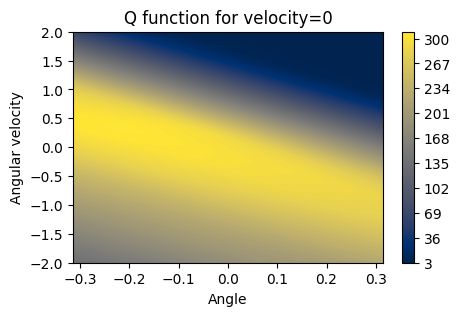

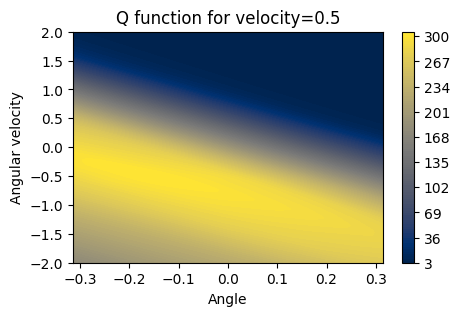

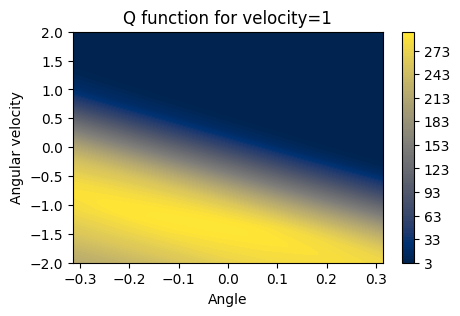

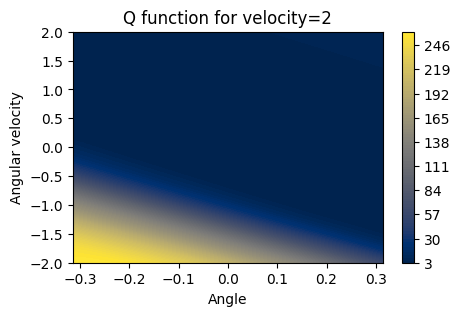

In [ ]:
# load model from pickle file
with open("tuned_DQN_Adam.pkl", 'rb') as file:
    policy_net_tuned = pickle.load(file)

cart_velocity = [0, 0.5, 1, 2]
visualise_DQN(policy_net_tuned, velocity=cart_velocity[0], q=True)

visualise_DQN(policy_net_tuned, velocity=cart_velocity[1], q=True)

visualise_DQN(policy_net_tuned, velocity=cart_velocity[2], q=True)

visualise_DQN(policy_net_tuned, velocity=cart_velocity[3], q=True)